# Part c) Variational Quantum Eigensolver (VQE)

## Introduction

In this part, we will implement the Variational Quantum Eigensolver (VQE) algorithm for finding the eigenvalues of the Hamiltonian studied in part b). VQE is a hybrid quantum-classical algorithm that uses a quantum computer to evaluate the expectation value of a Hamiltonian and a classical optimizer to find the parameters that minimize this expectation value, due to the variational principle.
The variational principle states that for any normalized state $\ket{\psi}$ the expectation value of the Hamiltonian $H$ is greater than or equal to the ground state energy $E_0$ of the system.

The VQE algorithm consists of the following steps:
1. Prepare a parameterized quantum state (ansatz)
2. Measure the expectation value of the Hamiltonian
3. Use a classical optimizer to adjust the parameters to minimize the expectation value
4. Repeat until convergence

The minimum expectation value found is an approximation of the ground state energy (smallest eigenvalue) of the Hamiltonian.

## Implementation
For VQE we need to parameterize our state, so we can vary those parameters to find the values for which the expectation value of the Hamiltonian is minimized. 

For parameterization we will simply rotate our qbit around two axes, Y and Z in the Bloch sphere. $$\ket{\psi(\theta, \phi)} = RZ(\phi)RY(\theta)\ket{0}$$

The rotation operators are defined as:
$$RZ(\phi) = e^{-i\frac{\phi}{2}Z} = \begin{pmatrix}
\cos(\frac{\phi}{2}) & -\sin(\frac{\phi}{2}) \\
\sin(\frac{\phi}{2}) & \cos(\frac{\phi}{2})
\end{pmatrix}$$
$$RY(\theta) = e^{-i\frac{\theta}{2}Y} = \begin{pmatrix}
\cos(\frac{\theta}{2}) & -\sin(\frac{\theta}{2}) \\
\sin(\frac{\theta}{2}) & \cos(\frac{\theta}{2})
\end{pmatrix}$$

The expectation value of the Hamiltonian will be used for our cost function to minimize. 
The Expectation value of some hamiltonian H is given by:
$$E(\theta, \phi) = \langle \psi(\theta, \phi) | H | \psi(\theta, \phi) \rangle$$


### Calculation of the expectation value of the Hamiltonian
In our implementation of the vqe for one and two qbits we can calculate the expectation value of the Hamiltonian by either using the full
matrix representation of the Hamiltonian or decomposing the Hamiltonian into Pauli operators and then sum the expectation values of the Pauli operators. 

In our example we use the full matrix representation of the Hamiltonian, but in later parts we will use the decomposition into Pauli operatorsm since it is more efficient if we have several qubits.

#### Decomposition of the Hamiltonian into Pauli operators
The Hamiltonian can be decomposed into Pauli operators as follows:
$$H = \sum_i c_i P_i$$


where $c_i$ are the coefficients and $P_i$ are the Pauli operators. The expectation value of the Hamiltonian is then be calculated as:
$$E(\theta, \phi) = \sum_i c_i \langle \psi(\theta, \phi) | P_i | \psi(\theta, \phi) \rangle$$

for one qubit $2\times 2$ Hamiltonian, the coefficients $c_i$ are given by:
$$c_0 = \frac{1}{2} Tr(H)$$
$$c_1 = \frac{1}{2} Tr(HX)$$

$$c_2 = \frac{1}{2} Tr(HY)$$
$$c_3 = \frac{1}{2} Tr(HZ)$$

where $X$, $Y$, and $Z$ are the Pauli operators.

### Minimization of the cost function

For the minimization of our cost function we iteratively try to find $(\theta, \phi)$ that minimizes the expectation value of the Hamiltonian.

For the minimization of our cost function we will use the `scipy.optimize.minimize` function. This function uses a variety of optimization algorithms to find the minimum of a function given it's parameters. Simply one can calculate the gradient of the function with respect to the parameters and then move in the direction of the negative gradient. By the theorem of the steepest descent, this will lead to the minimum of the function.


We have extended our vqe algorithm to include multiple variational layers, defining a layer as a modular of two rotations on each qbit and a entangling gate after each layer if we have two qbits. As an example of circuit design with two layers and two qbits we can use the following ansatz:
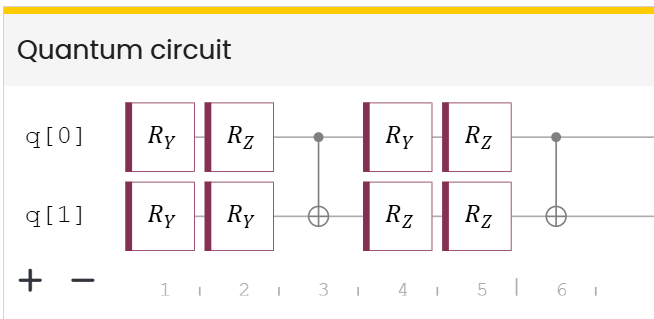


The above circuit is constructed in here: https://thequantumlaend.de/quantum-circuit-designer/

In [137]:
import numpy as np
import matplotlib.pyplot as plt
from quantum_computing.p1.vge.vge import VQE
from quantum_computing.p1.hamiltonian import hamiltonian as ham

## Setup Hamiltonian

First, let's recreate the Hamiltonian from part b)

In [138]:
ham = ham.Hamiltonian()

E1 = 0  # Energy of state |0⟩
E2 = 4  # Energy of state |1⟩
V11 = 3  # Interaction element
V12 = 0.2  # Interaction element
V21 = V12  # Interaction element (V12 = V21 for symmetry)
V22 = -V11  # Interaction element

H0 = ham.create_H0(E1, E2)
HI = ham.create_HI(V11, V12, V21, V22)

print("H0 = ")
print(H0)
print("\nHI = ")
print(HI)


H0 = 
[[0.+0.j 0.+0.j]
 [0.+0.j 4.+0.j]]

HI = 
[[ 3. +0.j  0.2+0.j]
 [ 0.2+0.j -3. +0.j]]


In [139]:
# Express in terms of Pauli matrices
H0_coeffs, HI_coeffs = ham.express_in_pauli_basis(H0, HI)

print("H0 coefficients:")
print(f"E = {H0_coeffs['E']}, Omega = {H0_coeffs['Omega']}")

print("\nHI coefficients:")
print(f"c = {HI_coeffs['c']}, omega_z = {HI_coeffs['omega_z']}, omega_x = {HI_coeffs['omega_x']}")

lambda_val = 0.5
H_reconstructed = ham.reconstruct_from_pauli(H0_coeffs, HI_coeffs, lambda_val)
H_direct = ham.create_total_H(H0, HI, lambda_val)

print("\nVerify reconstruction:")
print("H with lambda = 0.5 (direct):")
print(H_direct)
print("\nH with lambda = 0.5 (reconstructed from Pauli terms):")
print(H_reconstructed)

H0 coefficients:
E = (2+0j), Omega = (-2+0j)

HI coefficients:
c = 0j, omega_z = (3+0j), omega_x = (0.2+0j)

Verify reconstruction:
H with lambda = 0.5 (direct):
[[1.5+0.j 0.1+0.j]
 [0.1+0.j 2.5+0.j]]

H with lambda = 0.5 (reconstructed from Pauli terms):
[[1.5+0.j 0.1+0.j]
 [0.1+0.j 2.5+0.j]]


## VQE Implementation for Different λ Values

Let's run VQE for different values of $\lambda$ to compute the ground state energy as a function of the interaction strength.

For our Quantum circuit and ansatz we will use the following circuit:

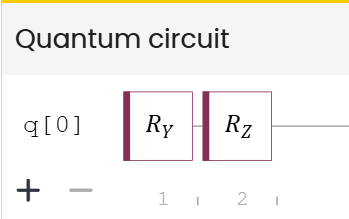

In [140]:
lambda_values = np.linspace(0, 1, 11)

vqe_eigenvalues = []
exact_eigenvalues = []

for lambda_val in lambda_values:
    H_total = H0 + lambda_val * HI
    
    print(f"\nSolving for λ = {lambda_val}")
    
    w, v = np.linalg.eigh(H_total)
    exact_eigenvalues.append(w)
    print(f"Exact eigenvalues: {w}")
    
    vqe = VQE(H_total,layers=1)
    
    best_energy = float('inf')
    for _ in range(5):
        params, energy = vqe.optimize()
        if energy < best_energy:
            best_energy = energy
    
    vqe_eigenvalues.append([best_energy, None]) 
    print(f"VQE ground state energy: {best_energy}")


Solving for λ = 0.0
Exact eigenvalues: [0. 4.]
VQE ground state energy: 0.0

Solving for λ = 0.1
Exact eigenvalues: [0.29988236 3.70011764]
VQE ground state energy: 0.29988235701173616

Solving for λ = 0.2
Exact eigenvalues: [0.59942869 3.40057131]
VQE ground state energy: 0.5994286879991992

Solving for λ = 0.30000000000000004
Exact eigenvalues: [0.89836485 3.10163515]
VQE ground state energy: 0.898364851686374

Solving for λ = 0.4
Exact eigenvalues: [1.19600995 2.80399005]
VQE ground state energy: 1.1960099503103319

Solving for λ = 0.5
Exact eigenvalues: [1.49009805 2.50990195]
VQE ground state energy: 1.490098048640722

Solving for λ = 0.6000000000000001
Exact eigenvalues: [1.76676192 2.23323808]
VQE ground state energy: 1.7667619242062054

Solving for λ = 0.7000000000000001
Exact eigenvalues: [1.82795349 2.17204651]
VQE ground state energy: 1.827953494659196

Solving for λ = 0.8
Exact eigenvalues: [1.56918682 2.43081318]
VQE ground state energy: 1.5691868154292505

Solving for λ 

## Result Visualization and Comparison

We will now visualize and compare the eigenvalues obtained using VQE with the exact eigenvalues from part b).

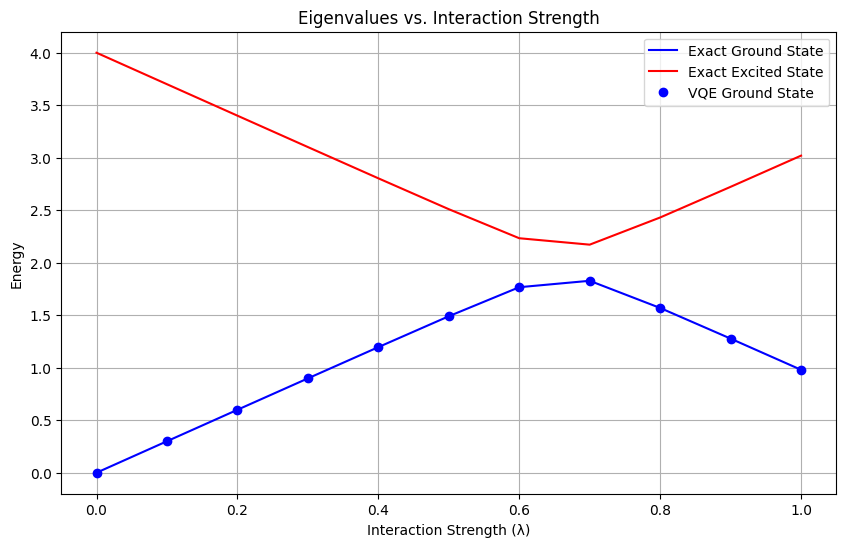

In [141]:
plt.figure(figsize=(10, 6))

# Plot exact eigenvalues
plt.plot(lambda_values, [eig[0] for eig in exact_eigenvalues], 'b-', label='Exact Ground State')
plt.plot(lambda_values, [eig[1] for eig in exact_eigenvalues], 'r-', label='Exact Excited State')

# Plot VQE results for ground state
plt.plot(lambda_values, [eig[0] for eig in vqe_eigenvalues], 'bo', label='VQE Ground State')

plt.xlabel('Interaction Strength (λ)')
plt.ylabel('Energy')
plt.title('Eigenvalues vs. Interaction Strength')
plt.legend()
plt.grid(True)
plt.show()

## Analysis of VQE Performance

Let us examine the convergence of the VQE algorithm by plotting the energy history for a specific λ value.

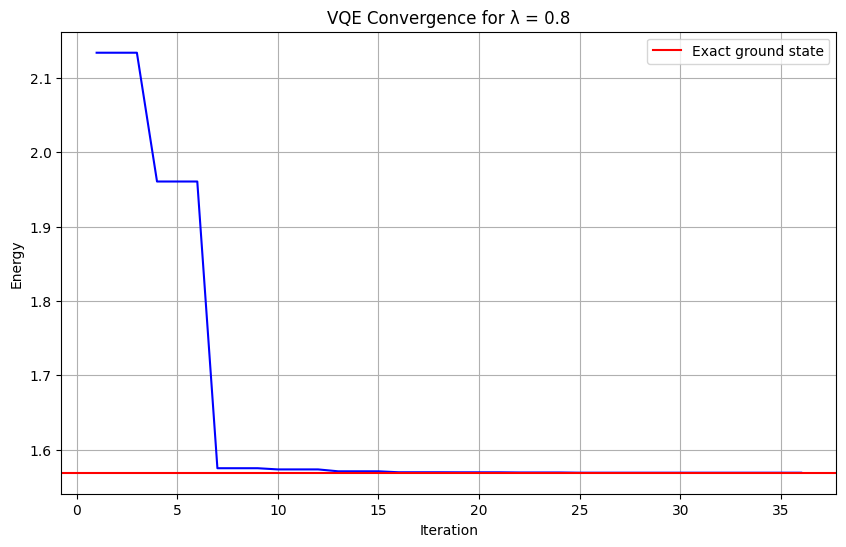

In [ ]:
lambda_detailed = 0.8
H_detailed = H0 + lambda_detailed * HI

vqe_detailed = VQE(H_detailed)
_, _ = vqe_detailed.optimize()

energy_history = vqe_detailed.get_energy_history()
iterations = list(range(1, len(energy_history) + 1))

plt.figure(figsize=(10, 6))
plt.plot(iterations, energy_history, 'b-')
plt.axhline(y=np.linalg.eigvalsh(H_detailed)[0], color='r', linestyle='-', label='Exact ground state')
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.title(f'VQE Convergence for λ = {lambda_detailed}')
plt.legend()
plt.grid(True)
plt.show()

## Discussion and Conclusion

VQE is able to find the ground state energy of the system across different values of the interaction strength parameter λ. The ground state energy evolves exactly the way it did from part b) and the approximated values are very close to the exact values.

In our case only applying one variational layer is sufficient to find the ground state energy in few iterations typically around 10 iterations. This is because the Hamiltonian is simple and the ansatz is expressive enough to capture the ground state. For more complex systems, more sophisticated ansatze would be required.

One drawback of VQE is that it is only able to find the ground state energy of the system, and not the excited states. This is because the optimization process only focuses on minimizing the expectation value of the Hamiltonian, which corresponds to the ground state energy. To find excited states, one would need to use a different approach, such as the Quantum Phase Estimation (QPE) algorithm.

In real quantum hardware, we would expect additional sources of error from quantum noise and imperfect measurements, but in our simulation, the main source of error is the expressivity of the ansatz and potential local minima in the optimization landscape.

For This part we Omiited to add  a qiskit comparison becasue of time contraint.